# Microarray design notebook

Jupyter Notebook that automates the experimental design process for DNA-microarray-based RNA structure analysis. 
The user inputs the RNA sequence, patch length, probe length, and probe spacing, and the notebook generates a set of patch oligos and microarray design files. The design files include sequences and $x,y$-positions for all probe oligos and controls, in a format that is ready for direct submission to Agilent for array fabrication. The output can be adapted for use with other microarray manufacturers. 

For more information, see the paper &ldquo;Measuring intramolecular connectivity in long RNA molecules using two-dimensional DNA patch-probe arrays,&rdquo; by Timothy K. Chiang, Ofer Kimchi, Herman K. Dhaliwal, Daniel A. Villarreal, Fernando F. Vasquez, Vinothan N. Manoharan, Michael P. Brenner, and Rees F. Garmann, _Nucleic Acids Research_ 2025.

Copyright 2024-2025 Ofer Kimchi, Timothy K. Chiang, Rees F. Garmann

This program is free software: you can redistribute it and/or modify it under
the terms of the GNU General Public License as published by the Free Software
Foundation, either version 3 of the License, or (at your option) any later
version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY
WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A
PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with
this program. If not, see <https://www.gnu.org/licenses/>.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Imports and definitions

In [ ]:
def designComplementRNADNA(seq):
    # Take an RNA sequence and design its reverse complement as a DNA sequence
    complementDict = {'G':'C', 'C':'G', 'U':'A', 'A':'T'}
    return(''.join([complementDict[seq[-i-1]] for i in range(len(seq))]))

In [ ]:
def makeCorners(num_subgrid_rows=148, num_subgrid_cols=43):
  # Define the pattern of dark and bright corners of the subarray.
  # Outputs the linear indices of dark and bright spots.

  # Dark Corners, 9 in upper left and 9 in lower right
  darkCorners = np.array([[0, 0], [0, 1], [0, 2],
                          [1, 0], [1, 1],
                          [2, 0], [2, 1],
                          [3, 0],
                          [4, 0],
                          [num_subgrid_rows-5, num_subgrid_cols-1],
                          [num_subgrid_rows-4, num_subgrid_cols-1],
                          [num_subgrid_rows-3, num_subgrid_cols-2],
                          [num_subgrid_rows-3, num_subgrid_cols-1],
                          [num_subgrid_rows-2, num_subgrid_cols-2],
                          [num_subgrid_rows-2, num_subgrid_cols-1],
                          [num_subgrid_rows-1, num_subgrid_cols-3],
                          [num_subgrid_rows-1, num_subgrid_cols-2],
                          [num_subgrid_rows-1, num_subgrid_cols-1]])

  # Bright Corners, 6 in lower left and 6 in upper right
  brightCorners = np.array([[0, num_subgrid_cols-2], [0, num_subgrid_cols-1],
                            [1, num_subgrid_cols-2], [1, num_subgrid_cols-1],
                            [2, num_subgrid_cols-1],
                            [3, num_subgrid_cols-1],
                            [num_subgrid_rows-4, 0],
                            [num_subgrid_rows-3, 0],
                            [num_subgrid_rows-2, 0], [num_subgrid_rows-2, 1],
                            [num_subgrid_rows-1, 0], [num_subgrid_rows-1, 1]])

  darkCorners = [tuple(i) for i in darkCorners]
  brightCorners = [tuple(i) for i in brightCorners]

  return(darkCorners, brightCorners)

In [ ]:
def make_Fullgrid(Subgrid):
  # Tile the subgrid across the 1x1M Agilent array (1068 rows, 912 columns)
  fullgrid_rows = 1068
  fullgrid_cols = 912

  # Calculate the rounded-up repetition factors and tile
  repeat_rows = (fullgrid_rows + Subgrid.shape[0]) // Subgrid.shape[0]
  repeat_cols = (fullgrid_cols + Subgrid.shape[1]) // Subgrid.shape[1]
  Fullgrid = np.tile(Subgrid, (repeat_rows, repeat_cols))

  # Crop the array to achieve exact desired dimensions
  Fullgrid = Fullgrid[:fullgrid_rows, :fullgrid_cols]

  return(Fullgrid)

In [ ]:
def flatten(l): #From StackExchange
    #Flatten a list -- given a list of sublists, concatenate the sublists into one long list
    return([item for sublist in l for item in sublist])

In [ ]:
def make_Array(RNA_seq, num_microarrays, probe_lengths=[12, 24],
               frac_unused_spots_to_use_for_extra_replicates=0.8):
  if frac_unused_spots_to_use_for_extra_replicates < 0 or frac_unused_spots_to_use_for_extra_replicates > 1:
    return('frac_unused_spots_to_use_for_extra_replicates must be between 0 & 1')

  len_RNA = len(RNA_seq)
  probe_start_index = 1  # start counting the probe positions from nt 1
  patch_start_index = 1  # start counting the patch positions from this nt


  # Find length of patches & number of unpatched gasket wells to use
  num_gasket_wells_total = 48 * num_microarrays
  min_num_unpatched_wells = 2 * num_microarrays
  num_patches = num_gasket_wells_total - min_num_unpatched_wells

  patch_len = int(np.ceil(len_RNA / num_patches))
  print('Patch length =', patch_len)

  patch_start_positions = np.arange(patch_start_index, len_RNA - (patch_len - 1) + patch_start_index, patch_len)
  print('Patch start positions (starting numbering at ' + str(patch_start_index) + '):', patch_start_positions)
  print('Number of used patches =', len(patch_start_positions))

  num_gasket_wells_used = int(np.floor(len_RNA / patch_len))  # don't include patches that overlap
  num_gasket_wells_leftover = num_patches - num_gasket_wells_used

  print('Number of gasket wells available for unpatched RNA =',
        num_gasket_wells_leftover + min_num_unpatched_wells)

  # Find probe spacing & number of possible replicates
  num_subgrid_rows = 149
  num_subgrid_cols = 43

  num_spots_total = num_subgrid_rows * num_subgrid_cols

  # Make corner pattern
  darkCorners, brightCorners = makeCorners()

  num_spots_dark = len(darkCorners)  # 9 dark (blue) spots in each of 2 corners
  num_spots_bright = len(brightCorners)  # 6 bright (yellow) spots in each of 2 corners
  num_spots_avail = num_spots_total - num_spots_dark - num_spots_bright

  min_num_replicates = 3
  num_replicates = 0  # to initialize -- must be < min_num_replicates
  probe_spacing = 0  # first, try to make every probe -- we will increase this by one

  while num_replicates < min_num_replicates:  # increase probe spacing by one
    probe_spacing += 1
    probe_start_positions = {}
    for probe_length in probe_lengths:
      probe_start_positions[probe_length] = np.arange(
        probe_start_index, len_RNA - (probe_length - 1) + probe_start_index, probe_spacing)

    num_unique_probe_seqs = np.sum([len(i) for i in probe_start_positions.values()])
    num_replicates = int(np.floor(num_spots_avail / num_unique_probe_seqs))

  num_unused_spots = num_spots_avail - (num_unique_probe_seqs * num_replicates)
  num_extra_replicates = int(num_unused_spots * frac_unused_spots_to_use_for_extra_replicates)
  print('Probe spacing =', probe_spacing)
  print('Number of replicates =', num_replicates)
  print('Number of spots available for controls =', num_unused_spots)
  print('Number of these spots used for further replicates =', num_extra_replicates)
  print('Probe start positions (starting numbering at ' + str(probe_start_index) + '):', probe_start_positions)


  # Create the patch and probe sequences
  patch_sequences = [designComplementRNADNA(
      RNA_seq[ patch_start - 1 : patch_start + patch_len - 1]
      ) for patch_start in patch_start_positions]
  unique_patch_indexes = np.unique(patch_sequences, return_index=True)[1]
  unique_patch_sequences = [patch_sequences[index] for index in sorted(unique_patch_indexes)]
  print('Patch sequences: ', unique_patch_sequences)

  probe_sequences = flatten([[designComplementRNADNA(
      RNA_seq[probe_start - 1: probe_start + probe_length - 1]).ljust(60, 'T')  # pad with 'T's until it's 60 nts long
      for probe_start in probe_start_positions[probe_length]] for probe_length in probe_lengths])
  unique_probe_indexes = np.unique(probe_sequences, return_index=True)[1]
  unique_probe_sequences = [probe_sequences[index] for index in sorted(unique_probe_indexes)]
  print('Probe sequences: ', unique_probe_sequences)

  if len(unique_patch_sequences) == len(patch_sequences):
    print('No replicate patch sequences')
  else:
    print('The following patches are present more than once')
    for patch_sequence in unique_patch_sequences:
      patch_sequence_count = patch_sequences.count(patch_sequence)
      if patch_sequence_count > 1:
        print(patch_sequence, patch_sequence_count)

  if len(unique_probe_sequences) == len(probe_sequences):
    print('No replicate probe sequences')
  else:
    print('The following probes are present more than once')
    for probe_sequence in unique_probe_sequences:
      probe_sequence_count = probe_sequences.count(probe_sequence)
      if probe_sequence_count > 1:
        print(probe_sequence, probe_sequence_count)

  # Design the microarray in 2D space
  pos_available = [(i, j) for i in range(num_subgrid_rows)
              for j in range(num_subgrid_cols)
              if ((i,j) not in darkCorners) and ((i,j) not in brightCorners)]

  # Generate list of indices of free spots available for random distribution of probe sequences
  all_inds_probes = np.arange(len(pos_available))
  np.random.shuffle(all_inds_probes)
  inds_Probes = all_inds_probes[: num_unique_probe_seqs * num_replicates].reshape(
      (num_unique_probe_seqs, num_replicates))

  # The integer value of the element in Subgrid[row,col] is the probe number at that (row,col)
  Subgrid = np.zeros((num_subgrid_rows, num_subgrid_cols), dtype=int) - 3
  for probeNum in range(num_unique_probe_seqs):
    for replicate in range(num_replicates):
      position = pos_available[inds_Probes[probeNum,replicate]]
      Subgrid[position[0],position[1]] = probeNum
    num_rep_for_probenum = len([i for i in flatten(Subgrid) if i == probeNum])
    if num_rep_for_probenum != num_replicates:
      print('Wrong number of replicates for probeNum = ' + str(probeNum) +
            ': ' + str(num_rep_for_probenum))

  # print('Check', num_unused_spots==len(all_inds_probes) - num_unique_probe_seqs*num_replicates)
  probes_for_extra_replicates = np.random.choice(
      num_unique_probe_seqs, size=num_extra_replicates, replace=False)
  for unused_probe_idx in range(num_extra_replicates):
    position = pos_available[all_inds_probes[num_unique_probe_seqs * num_replicates + unused_probe_idx]]
    Subgrid[position[0],position[1]] = probes_for_extra_replicates[unused_probe_idx]

  # Define the probe number labels for darkCorners and brightCorners as -1 and -2 respectively
  dC_array = np.array(darkCorners)
  bC_array = np.array(brightCorners)
  Subgrid[dC_array[:, 0], dC_array[:, 1]] = -1
  Subgrid[bC_array[:, 0], bC_array[:, 1]] = -2

  # Tile the subgrid to make the full grid
  Fullgrid = make_Fullgrid(Subgrid)

  return(unique_patch_sequences, unique_probe_sequences, Subgrid, Fullgrid)

In [ ]:
# Agilent template file:
# Column	Row	ProbeID	Sequence	Feature Number	ControlType
# 1	1	probe1245	GCACGCCCTTCGTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT	1
# 2	1	probe0634	XXXXXXXXXXXXTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT	2
# ...
# ...
# 26	1	Free_Spot		26
# ...
# ...
# 912	1068	probeXXXX	XXXXXXXXXXXXTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT	912*1068
def make_agilent_file(unique_probe_sequences, Fullgrid, save_file_name=None):
  columns = []
  rows = []
  probeIDs = []
  sequences = []
  feature_numbers = []
  ft_num = 1
  control_types = []
  for i in range(Fullgrid.shape[0]):
    for j in range(Fullgrid.shape[1]):
      rows += [i + 1]
      columns += [j + 1]
      feature_numbers += [ft_num]
      ft_num += 1
      control_types += ['']

      seq_index = Fullgrid[i, j]
      if seq_index >= 0:
        probeIDs += ['probe' + str(seq_index + 1).zfill(4)]
        sequences += [unique_probe_sequences[seq_index]]
      else:
        if seq_index == -1:
          probeIDs += ['Light spot']
          sequences += ['A'*60]
        elif seq_index == -2:
          probeIDs += ['Dark spot']
          sequences += ['T'*60]
        elif seq_index == -3:
          probeIDs += ['Free spot']
          sequences += ['']
        else:
          probeIDs += ['???']
          sequences += ['???']

  agilent_file = pd.DataFrame({'Column': columns,
                               'Row': rows,
                               'ProbeID': probeIDs,
                               'Sequence': sequences,
                               'Feature Number': feature_numbers,
                               'Control Type': control_types})
  if save_file_name is not None:
    agilent_file.to_csv(save_file_name + '.txt', sep='\t', index=False)
  return(agilent_file)

In [ ]:
def get_seq_fullgrid_from_agilent_file(agilent_file):
  seq_fullgrid = dict()  # np.zeros((agilent_file.Row.max(), agilent_file.Column.max()))
  for agilent_file_row in range(agilent_file.shape[0]):
    seq_fullgrid[(agilent_file.Row.iloc[agilent_file_row] - 1,
             agilent_file.Column.iloc[agilent_file_row] - 1
             )] = agilent_file.Sequence.iloc[agilent_file_row]
  return(seq_fullgrid)

In [ ]:
# Check that the agilent file was created correctly
# (i.e. that the inputs and outputs of the agilent file creation function agree)
def check_fullgrid_agrees_with_agilent_file(Fullgrid, probe_seqs, agilent_file):
  seq_fullgrid = dict()
  for i in range(Fullgrid.shape[0]):
    for j in range(Fullgrid.shape[1]):
      seq_index = Fullgrid[i, j]
      if seq_index >= 0:
        seq_fullgrid[(i, j)] = probe_seqs[seq_index]
      elif seq_index == -1:
        seq_fullgrid[(i, j)] = 'A'*60
      elif seq_index == -2:
        seq_fullgrid[(i, j)] = 'T'*60
      elif seq_index == -3:
        seq_fullgrid[(i, j)] = ''
      else:
        print(i, j, 'Huh?')

  seq_fullgrid_check = get_seq_fullgrid_from_agilent_file(agilent_file)
  return(seq_fullgrid == seq_fullgrid_check)

# User-specified parameters

In [ ]:
RNA_sequence = ('GGG' +
            'AGTAAACTTACCAATCAAAAGACCTAACCAACAGGACTGTCGTGGTCATTTATGCTGTTGGGGGACATAGGGGGAAAACATATTGCCTTCTTCTACAAGAGGCCTTCAGTCGCCATAATTACTTGGCGCCCAATTTTGGGTTTCAGTTGCTGTTTCCAGCTATGGGGAGAGGTAAGGTTAAACCAAACCGTAAATCGACGGGTGACAATTCGAATGTTGTTACTATGATTAGAGCTGGAAGCTATCCTAAGGTCAATCCGACTCCAACGTGGGTCAGAGCCATACCTTTCGAAGTGTCAGTTCAATCTGGTATTGCTTTTAAAGTACCGGTCGGGTCACTATTTTCGGCAAATTTCCGGACAGATTCCTTTACAAGCGTCACAGTGATGAGTGTCCGTGCTTGGACCCAGTTAACACCGCCAGTAAATGAGTACAGTTTTGTGAGGCTGAAGCCATTGTTCAAGACTGGTGACTCTACTGAGGAGTTCGAAGGGCGTGCATCAAACATCAACACACGAGCTTCTGTAGGGTACAGGATTCCAACTAATTTGCGTCAGAATACTGTGGCAGCCGACAATGTATGCGAAGTAAGAAGCAACTGTCGACAAGTCGCCTTGGTTATTTCGTGTTGTTTTAACTGAACCTCGACATAAGCCTTTTGGATCGAAGGTTAAACGATCCGCTCCTCGCTTGAGCTTGAGGCGGCGTATCTCTTATGTCAACAGAGACACTTTGGTCTATGGTTGTATAACAATAGATAGACTCCCGTTTGCAAGATTAGGGTTAACAGATCTTGCCGTTAGTCTGGTTAGCGCGTAACCGGCCTTGATTTATGGAATAGATCCATTGTCCAATGGCTTTGCCAATGGAACGCCGACGTGGCTGTATAATACGTCGTTGACAAGTACGAAATCTTGTTAGTGTTTTTCCCTCCACTTAAATCGAAGGGTTTTGTTTTGGTCTTCCCGAACGCATACGTTAGTGTGACTACCGTTGTTCGAAACAAGTAAAACAGGAAGGGGGTTCGAATCCCTCCCTAACCGCGGGTAAGCGGCCCAA'
            ).replace('T', 'U')  # This is the STMV sequence studied in the manuscript
output_file_name = 'STMV_Auto_Agilent_File_12nt_probes'  # The code will save the agilent file under this filename
num_microarrays = 1  # Number of microarrays to use to measure the structure of the sequence
probe_lengths = [12, 24]  # List of probe lengths to use. Our study used 12-mers and 24-mers.
frac_unused_spots_to_use_for_extra_replicates = 1.  # float between zero and one. If zero, all probes will have 3 replicates; if >0, some probes will have 4 replicates.

# Create Agilent file

In [ ]:
# If the notebook is run in Google Colab,
# the file will be saved within the Google Colab as [output_file_name].txt
# Remember to download the file as it will be lost when Colab runtime is recycled
patch_seqs, probe_seqs, Subgrid, Fullgrid = make_Array(
    RNA_seq=RNA_sequence,
    num_microarrays=num_microarrays,
    probe_lengths=probe_lengths,
    frac_unused_spots_to_use_for_extra_replicates=frac_unused_spots_to_use_for_extra_replicates)
agilent_file = make_agilent_file(probe_seqs, Fullgrid, save_file_name=output_file_name)

Patch length = 24
Patch start positions (starting numbering at 1): [   1   25   49   73   97  121  145  169  193  217  241  265  289  313
  337  361  385  409  433  457  481  505  529  553  577  601  625  649
  673  697  721  745  769  793  817  841  865  889  913  937  961  985
 1009 1033]
Number of used patches = 44
Number of gasket wells available for unpatched RNA = 4
Probe spacing = 1
Number of replicates = 3
Number of spots available for controls = 107
Number of these spots used for further replicates = 107
Probe start positions (starting numbering at 1): {12: array([   1,    2,    3, ..., 1049, 1050, 1051]), 24: array([   1,    2,    3, ..., 1037, 1038, 1039])}
Patch sequences:  ['CTTTTGATTGGTAAGTTTACTCCC', 'CCACGACAGTCCTGTTGGTTAGGT', 'TATGTCCCCCAACAGCATAAATGA', 'GAAGAAGGCAATATGTTTTCCCCC', 'TATGGCGACTGAAGGCCTCTTGTA', 'ACCCAAAATTGGGCGCCAAGTAAT', 'CCATAGCTGGAAACAGCAACTGAA', 'GGTTTGGTTTAACCTTACCTCTCC', 'TCGAATTGTCACCCGTCGATTTAC', 'CAGCTCTAATCATAGTAACAACAT', 'TCGGATTGACCTTAGGATAGCTT

# Test the file generated

In [ ]:
# Visualize the file
agilent_file

,Column,Row,ProbeID,Sequence,Feature Number,Control Type
0,1,1,Light spot,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,1,
1,2,1,Light spot,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,2,
2,3,1,Light spot,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,3,
3,4,1,probe1030,AGGGAGGGATTCTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...,4,
4,5,1,probe0297,TTGAACTGACACTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...,5,
...,...,...,...,...,...,...
974011,908,1068,probe0195,ACCCGTCGATTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...,974012,
974012,909,1068,probe1420,CATCACTGTGACGCTTGTAAAGGATTTTTTTTTTTTTTTTTTTTTT...,974013,
974013,910,1068,probe0884,TATTATACAGCCTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...,974014,
974014,911,1068,probe0040,TGACCACGACAGTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...,974015,


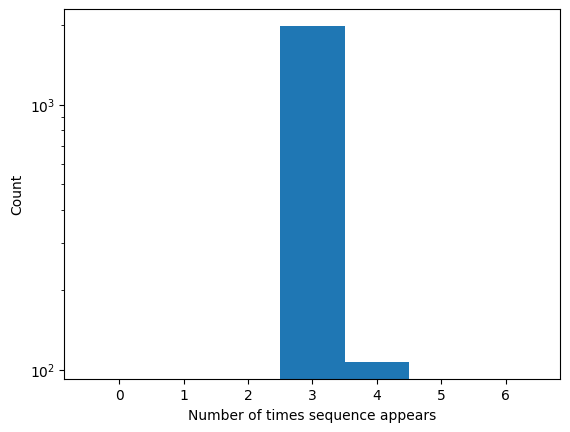

In [ ]:
# Histogram the number of times each sequence appears in the Subgrid
num_times_each_seq_appears = [len([i for i in flatten(Subgrid) if i==j])
  for j in np.unique(Subgrid) if j >= 0]  # ignore dark & bright spots, etc.
plt.figure()
plt.hist(num_times_each_seq_appears,
         bins=np.linspace(0,
                          max(num_times_each_seq_appears) + 3,
                          max(num_times_each_seq_appears) + 4) - 0.5)
plt.yscale('log')
plt.ylabel('Count')
plt.xlabel('Number of times sequence appears')
plt.show()

In [ ]:
# Check that the file generated is self-consistent
check_fullgrid_agrees_with_agilent_file(Fullgrid, probe_seqs, agilent_file)

True